# **Install required Packages:**

In [1]:
!pip install pandas scikit-learn matplotlib seaborn skl2onnx onnxruntime onnx graphviz pydot
!pip install -U imbalanced-learn

In [2]:
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import matplotlib.pyplot as plt
import gzip
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from scipy.stats import zscore
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer

import graphviz
import numpy as np

C:\Users\kiran\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Importing the Dataset

In [4]:
file_path = 'data_public.csv'
data = pd.read_csv(file_path)


## Summary statistics, visualization

In [5]:
data_info = {
    "head": data.head(),
    "info": data.info(),
    "description": data.describe(),
    "class_distribution": data['Class'].value_counts() if 'Class' in data.columns else "Target column missing."
}

data_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 16 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   A       1200000 non-null  float64
 1   B       1200000 non-null  float64
 2   C       1200000 non-null  float64
 3   D       1200000 non-null  float64
 4   E       1200000 non-null  float64
 5   F       1200000 non-null  float64
 6   G       1200000 non-null  float64
 7   H       1200000 non-null  float64
 8   I       1200000 non-null  float64
 9   J       1200000 non-null  float64
 10  K       1200000 non-null  float64
 11  L       1200000 non-null  float64
 12  M       1200000 non-null  float64
 13  N       1200000 non-null  float64
 14  O       1200000 non-null  float64
 15  Class   1200000 non-null  int64  
dtypes: float64(15), int64(1)
memory usage: 146.5 MB


{'head':             A          B           C          D           E          F  \
 0  231.420023 -12.210984  217.624839 -15.611916  140.047185  76.904999   
 1  -38.019270 -14.195695    9.583547  22.293822  -25.578283 -18.373955   
 2  -39.197085 -20.418850   21.023083  19.790280  -25.902587 -19.189004   
 3  221.630408  -5.785352  216.725322  -9.900781  126.795177  85.122288   
 4  228.558412 -12.447710  204.637218 -13.277704  138.930529  91.101870   
 
             G           H          I           J           K         L  \
 0  131.591871  198.160805  82.873279  127.350084  224.592926 -5.992983   
 1   -0.094457  -33.711852  -8.356041   23.792402    4.199023  2.809159   
 2   -2.953836  -25.299219  -6.612401   26.285392    5.911292  6.191587   
 3  108.857593  197.640135  82.560019  157.105143  212.989231 -3.621070   
 4  115.598954  209.300011  89.961688  130.299732  201.795100 -1.573922   
 
            M           N           O  Class  
 0 -14.689648  143.072058  153.439659    

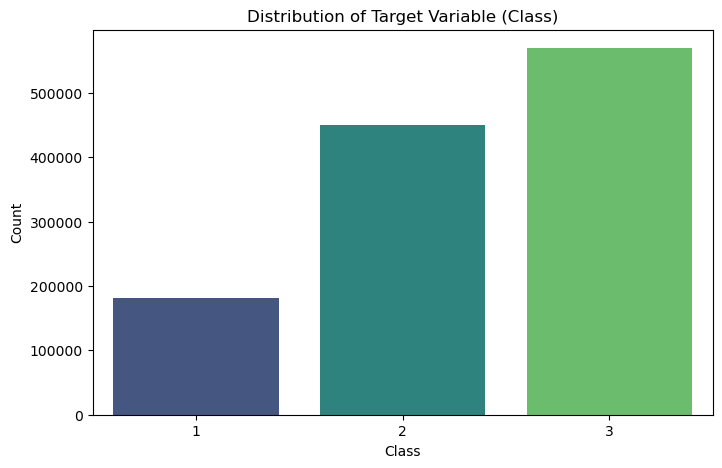

In [6]:
# Plot target variable distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='Class', palette='viridis')
plt.title('Distribution of Target Variable (Class)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

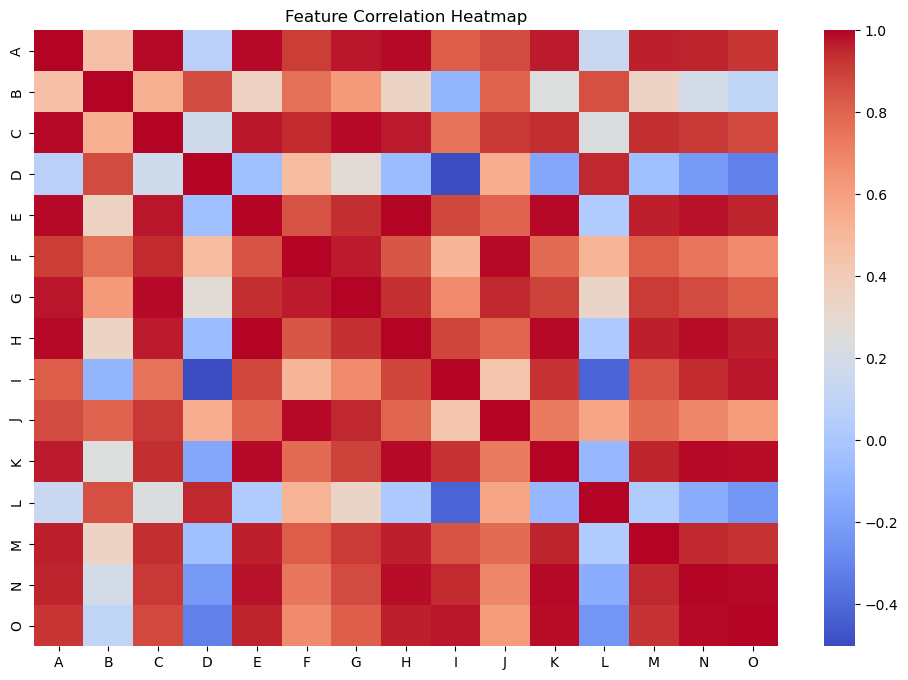

In [7]:
# Plot correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = data.iloc[:, :-1].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [8]:
#Test for missing values
print("Missing values:\n", data.isnull().sum())

Missing values:
 A        0
B        0
C        0
D        0
E        0
F        0
G        0
H        0
I        0
J        0
K        0
L        0
M        0
N        0
O        0
Class    0
dtype: int64


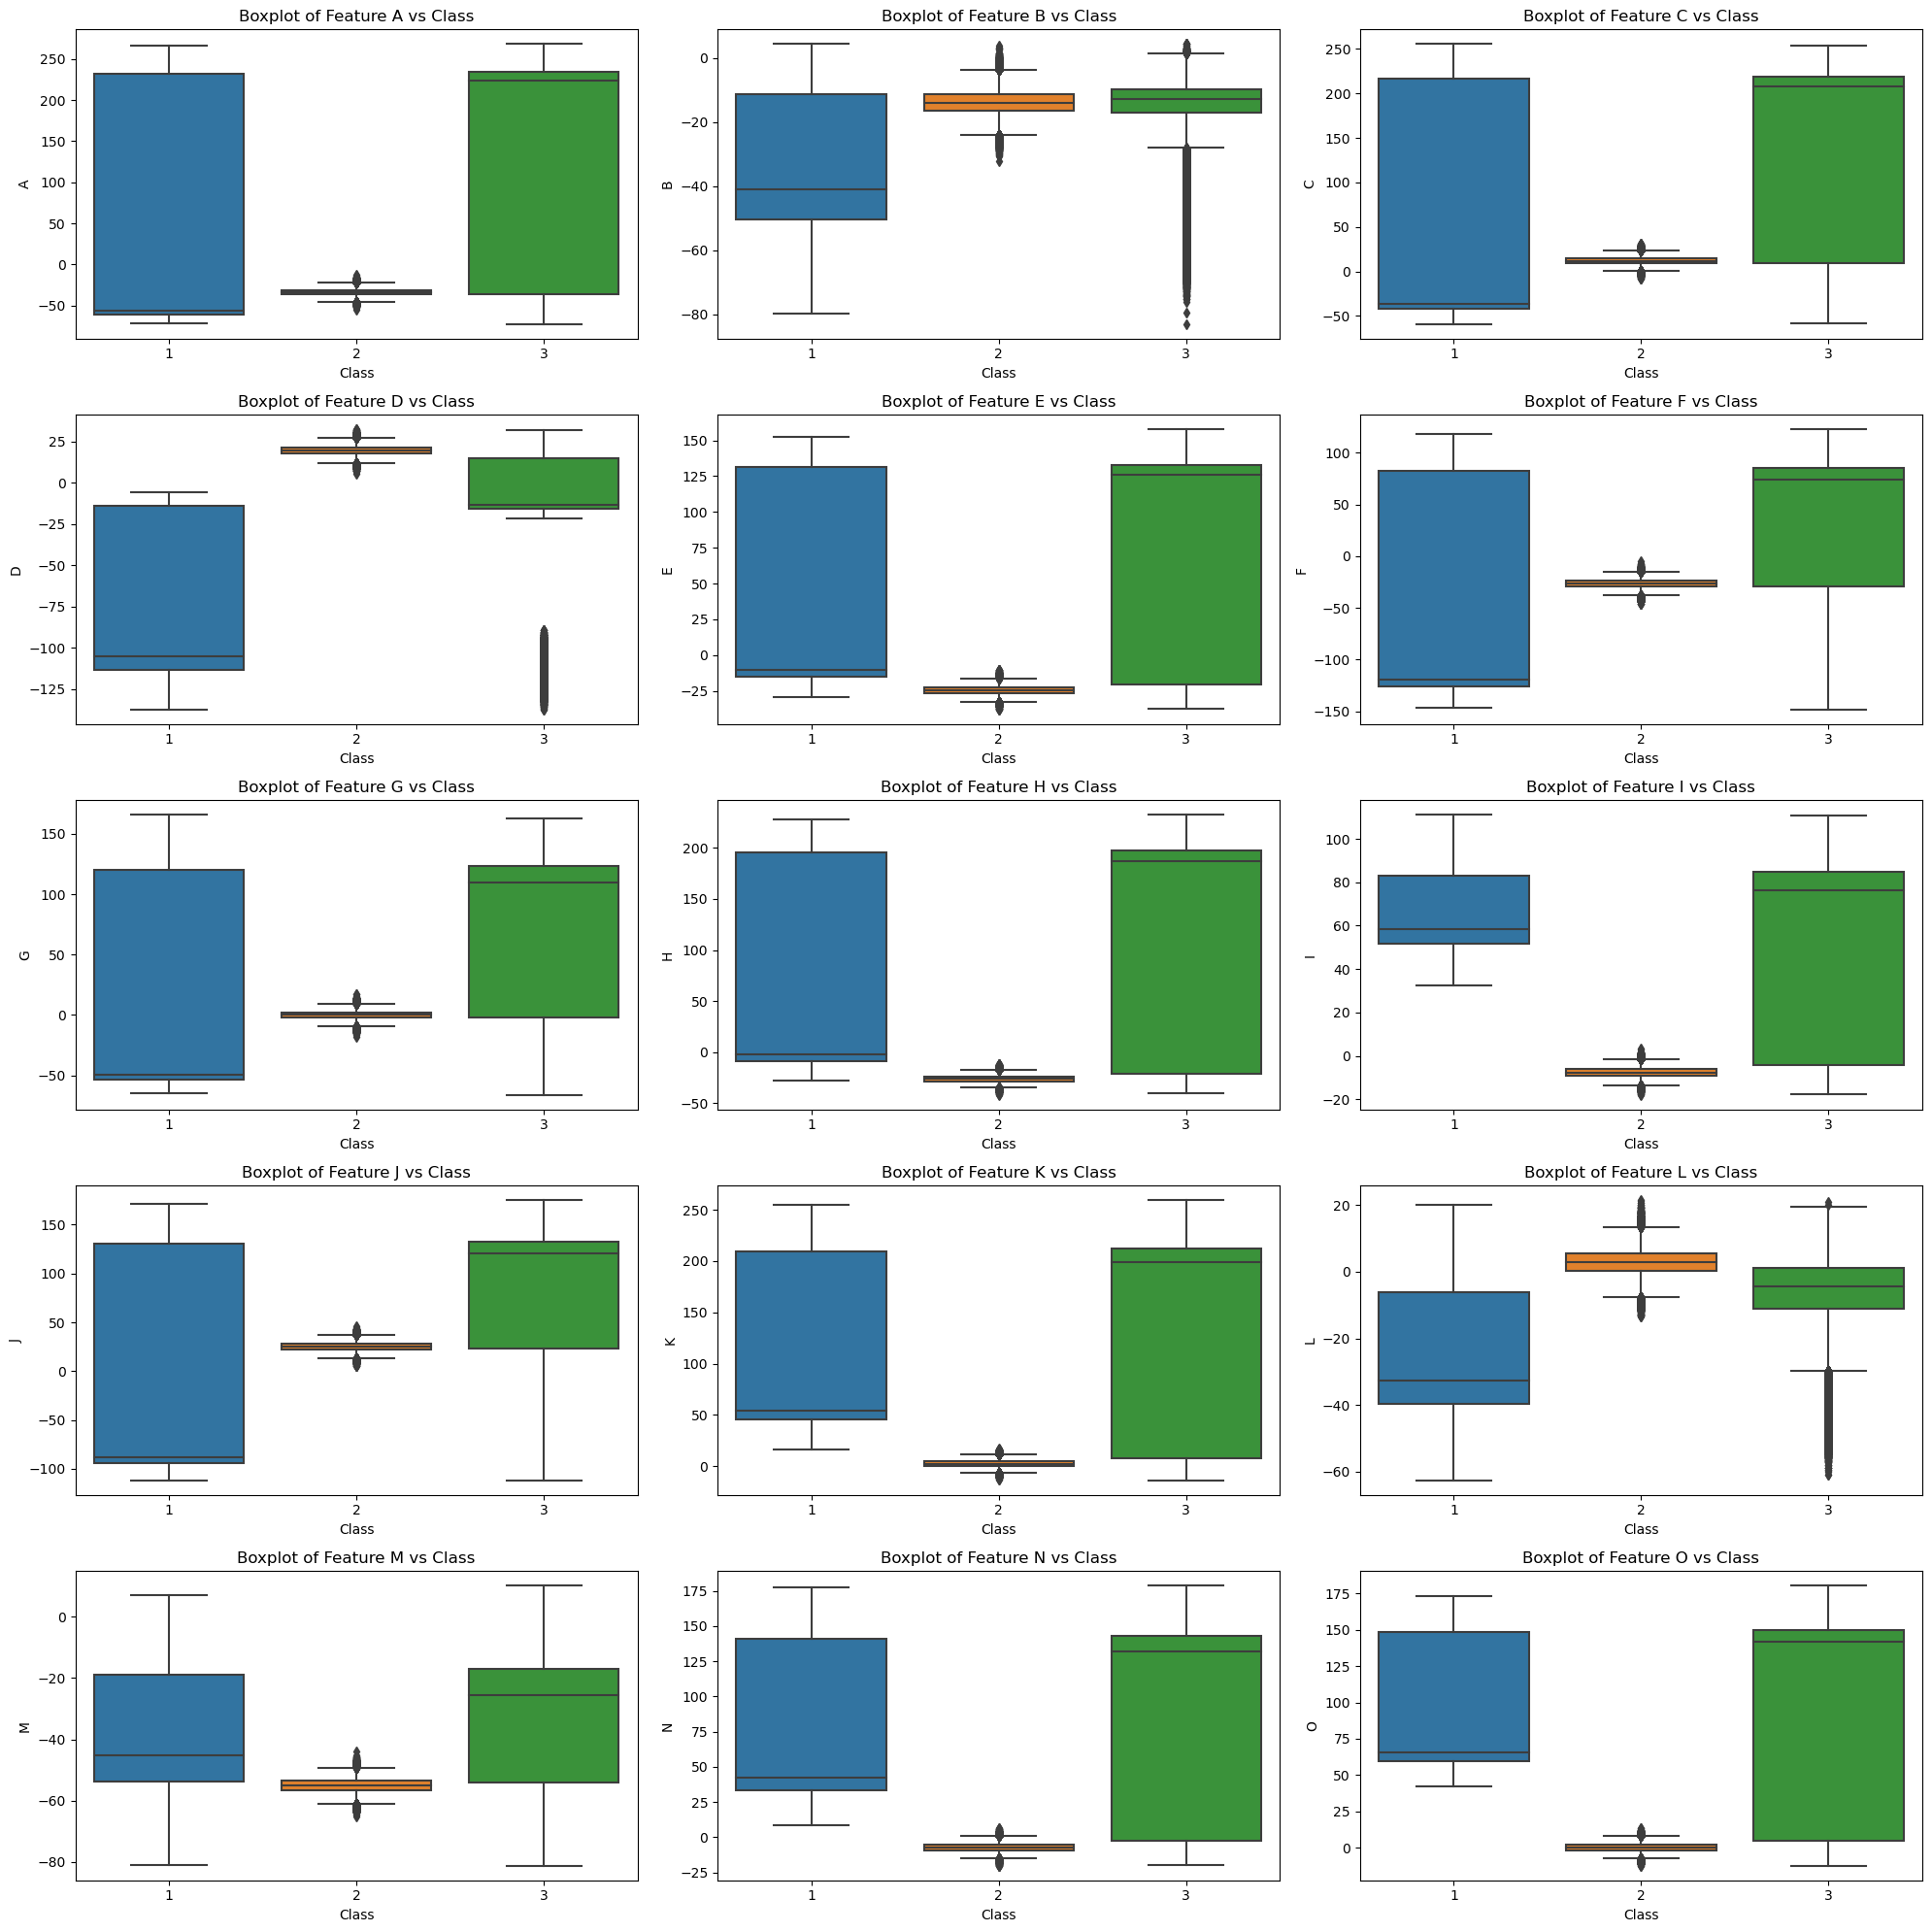

In [9]:
features = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']  # List all feature columns
rows, cols = 5, 3
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(data=data, x='Class', y=feature, ax=axes[i])
    axes[i].set_title(f'Boxplot of Feature {feature} vs Class')
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

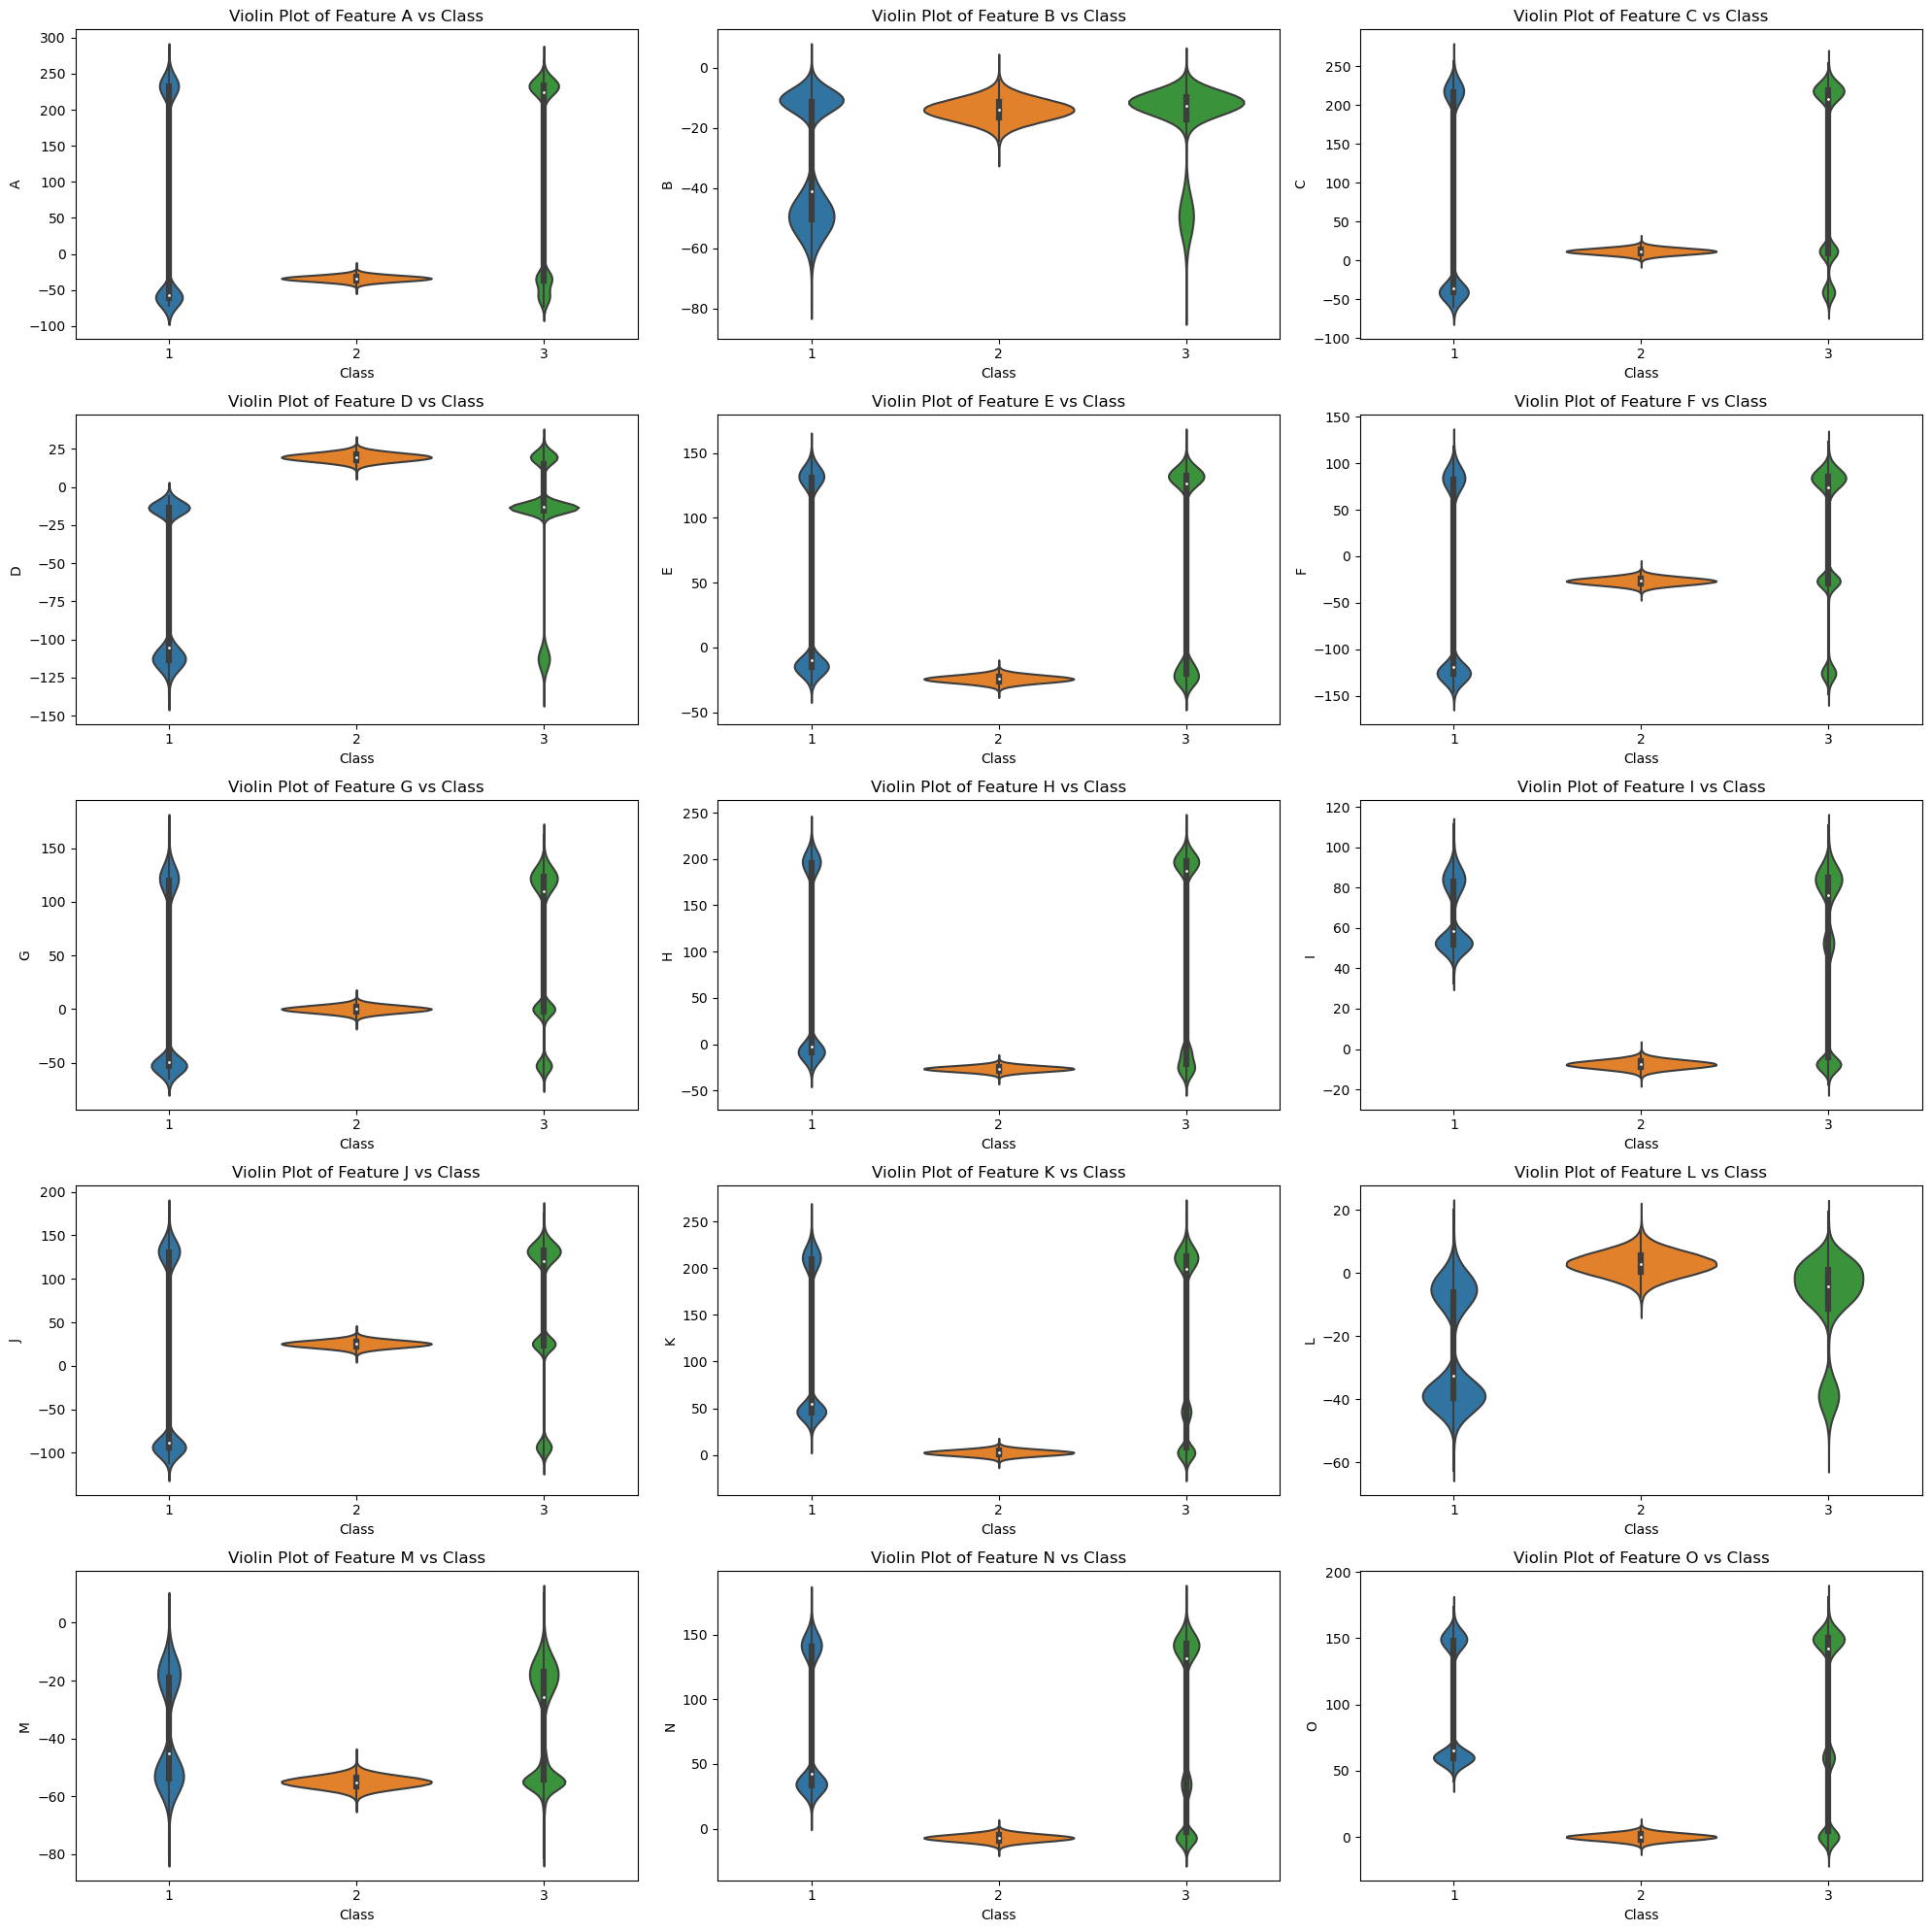

In [10]:
rows, cols = 5, 3
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.violinplot(data=data, x='Class', y=feature, ax=axes[i])
    axes[i].set_title(f'Violin Plot of Feature {feature} vs Class')
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [11]:
## Handle missing values
num_imputer = SimpleImputer(strategy='mean')  # For numerical columns
num_cols = data.select_dtypes(include=['float64', 'int64']).columns

data[num_cols] = num_imputer.fit_transform(data[num_cols])

## Remove duplicates
data = data.drop_duplicates()

In [12]:
z_scores = np.abs(zscore(data[num_cols.drop('Class', errors='ignore')]))
outlier_threshold = 3
data = data[(z_scores < outlier_threshold).all(axis=1)]

In [13]:
data_info = {
    "head": data.head(),
    "info": data.info(),
    "description": data.describe(),
    "class_distribution": data['Class'].value_counts() if 'Class' in data.columns else "Target column missing."
}

data_info

<class 'pandas.core.frame.DataFrame'>
Index: 1193716 entries, 0 to 1199999
Data columns (total 16 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   A       1193716 non-null  float64
 1   B       1193716 non-null  float64
 2   C       1193716 non-null  float64
 3   D       1193716 non-null  float64
 4   E       1193716 non-null  float64
 5   F       1193716 non-null  float64
 6   G       1193716 non-null  float64
 7   H       1193716 non-null  float64
 8   I       1193716 non-null  float64
 9   J       1193716 non-null  float64
 10  K       1193716 non-null  float64
 11  L       1193716 non-null  float64
 12  M       1193716 non-null  float64
 13  N       1193716 non-null  float64
 14  O       1193716 non-null  float64
 15  Class   1193716 non-null  float64
dtypes: float64(16)
memory usage: 154.8 MB


{'head':             A          B           C          D           E          F  \
 0  231.420023 -12.210984  217.624839 -15.611916  140.047185  76.904999   
 1  -38.019270 -14.195695    9.583547  22.293822  -25.578283 -18.373955   
 2  -39.197085 -20.418850   21.023083  19.790280  -25.902587 -19.189004   
 3  221.630408  -5.785352  216.725322  -9.900781  126.795177  85.122288   
 4  228.558412 -12.447710  204.637218 -13.277704  138.930529  91.101870   
 
             G           H          I           J           K         L  \
 0  131.591871  198.160805  82.873279  127.350084  224.592926 -5.992983   
 1   -0.094457  -33.711852  -8.356041   23.792402    4.199023  2.809159   
 2   -2.953836  -25.299219  -6.612401   26.285392    5.911292  6.191587   
 3  108.857593  197.640135  82.560019  157.105143  212.989231 -3.621070   
 4  115.598954  209.300011  89.961688  130.299732  201.795100 -1.573922   
 
            M           N           O  Class  
 0 -14.689648  143.072058  153.439659    

In [14]:
target_col = 'Class'
X = data.drop(columns=[target_col])
y = data[target_col]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),                  # Feature Scaling
    ('pca',PCA(n_components=0.98)),
    ('rf', RandomForestClassifier(
        n_estimators=108,
        max_depth=7,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1,
        bootstrap=False,
        min_samples_leaf=1,
        min_samples_split=4
    ))
])

In [16]:
# Train the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.98)),
                ('rf',
                 RandomForestClassifier(bootstrap=False,
                                        class_weight='balanced', max_depth=7,
                                        min_samples_split=4, n_estimators=108,
                                        n_jobs=-1, random_state=42))])

In [17]:
# Evaluate the model
y_pred = pipeline.predict(X_test)

In [18]:
# Classification Report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         1.0       0.51      0.56      0.53     35486
         2.0       0.75      1.00      0.86     89665
         3.0       0.80      0.57      0.66    113593

    accuracy                           0.73    238744
   macro avg       0.69      0.71      0.68    238744
weighted avg       0.74      0.73      0.72    238744



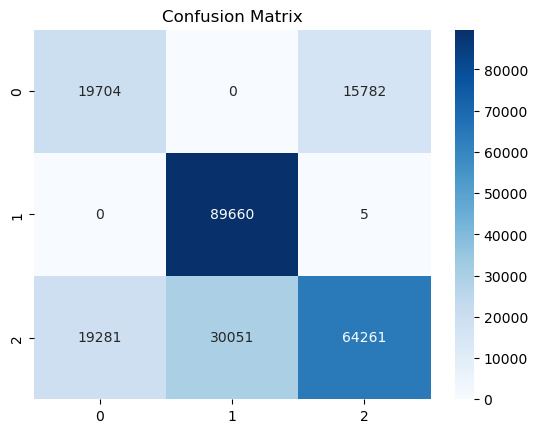

In [19]:
# Confusion Matrix
confusion_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Export the model to ONNX format
input_types = dict([(x, FloatTensorType([None, 1])) for x in X_train.columns.values])

try:
    model_onnx = convert_sklearn(pipeline,
                                 'random_forest_pipeline',
                                initial_types=list(input_types.items()))
except Exception as e:
    print(e)

with open("random_forest_pipeline.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

print(f"Model exported to ONNX format and saved as random_forest_pipeline.onnx")

Model exported to ONNX format and saved as random_forest_pipeline.onnx


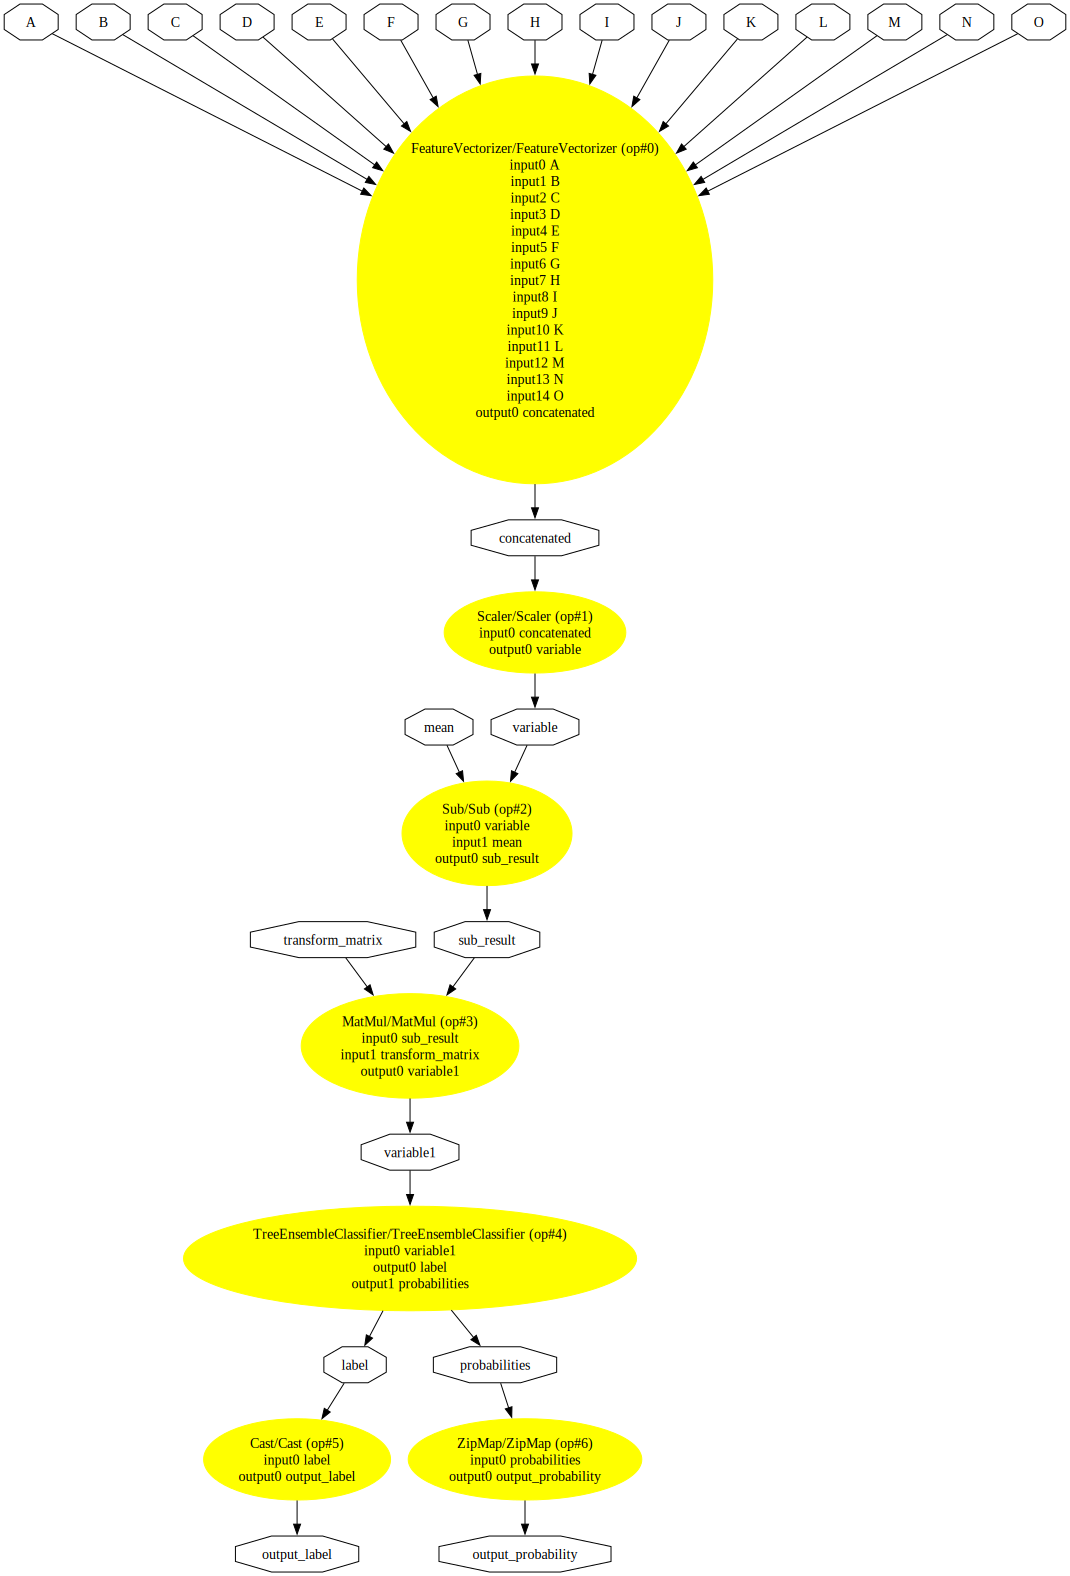

In [21]:
pydot_graph = GetPydotGraph(model_onnx.graph,
                            name=model_onnx.graph.name,
                            rankdir="TB",
                            node_producer=GetOpNodeProducer("docstring",
                                                            color="yellow",
                                                            fillcolor="yellow",
                                                            style="filled"))

graphviz.Source(pydot_graph.to_string())

In [22]:
import onnxruntime as rt

from onnx.tools.net_drawer import GetPydotGraph, GetOpNodeProducer

import graphviz
inputs_onnx = {k: np.array(v).astype(np.float32)[:, np.newaxis] for k, v in X_test.to_dict(orient='list').items()}

session_onnx = rt.InferenceSession("random_forest_pipeline.onnx")
predict_onnx = session_onnx.run(None, inputs_onnx)
print("predict", predict_onnx)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

